In [1]:
from utils.load import load_dataset, load_summary_files, taxonomy_assignments
from refactor.utils.compute import silhouette_analysis
from timebudget import timebudget

fig_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/NCS/'
with timebudget('load orig data'):
    O = load_dataset()
    
with timebudget('load folds'):    
    folds_1 = load_summary_files(data_type='NM_cc',lambda_TE=1.0, aug=1, load_gmm=True, fold_list=np.arange(21))
    folds_0 = load_summary_files(data_type='NM_cc',lambda_TE=0.0, aug=0, load_gmm=False)

load orig data took 270.11ms
load folds took 12.684sec


In [2]:
mse_E=[]
mse_T=[]
for i in folds_0.keys():
    test_ind = folds_0[i]['test_ind']
    mse_E.append(np.mean(((O['XE'][test_ind,:]-folds_0[i]['XrE'][test_ind,:])**2)))
    mse_T.append(np.mean(((O['XT'][test_ind,:]-folds_0[i]['XrT'][test_ind,:])**2)))

fold_id = np.array(list(folds_0.keys()))
best_T_model_key = np.argsort(mse_T)
best_T_model_key = fold_id[best_T_model_key]
best_E_model_key = np.argsort(mse_E)
best_E_model_key = fold_id[best_E_model_key]

In [3]:
mse_E=[]
mse_T=[]
for i in folds_0.keys():
    test_ind = folds_1[i]['test_ind']
    mse_E.append(np.mean(((O['XE'][test_ind,:]-folds_1[i]['XrE'][test_ind,:])**2)))
    mse_T.append(np.mean(((O['XT'][test_ind,:]-folds_1[i]['XrT'][test_ind,:])**2)))

fold_id = np.array(list(folds_1.keys()))
best_TE_model_key = np.argsort(np.array(mse_T)+np.array(mse_E))
best_TE_model_key = fold_id[best_TE_model_key]
print(best_TE_model_key[:5])

[17 14  2 15 13]


In [4]:
#Based on 95% test cells (calculated in denovo_clustering notebook):
best_TE_model_key = np.array([11,17,1,14,10])

#### Overall average silhouette scores on test cells with uncoupled representations

In [5]:
#Uncoupled zE with different resolution of taxonomy:
s_mean_list_E_to_tax=[]
s_mean_list_T_to_tax=[]
n_classes_list=[]
n_best=5

for n_required_classes in np.arange(10,54,1):
    merged_labels,n_classes = taxonomy_assignments(O['cluster'].copy(),datadict=O.copy(),n_required_classes=n_required_classes, merge_on='well_sampled')
    for k in range(n_best):
        n_classes_list.append(n_classes)
        all_inds = O['well_sampled_ind'].copy()
        test_inds = folds_0[best_E_model_key[k]]['well_sampled_test_ind'].copy()

        zE = folds_0[best_E_model_key[k]]['zE'][test_inds,:].copy()
        lbl = merged_labels[test_inds].copy()
        df_E_sample,df_E_label = silhouette_analysis(z=zE,lbl=lbl)
        s_mean_list_E_to_tax.append(df_E_sample['sil'].mean())
        
        zT = folds_0[best_T_model_key[k]]['zT'][test_inds,:].copy()
        lbl = merged_labels[test_inds].copy()
        df_T_sample,df_T_label = silhouette_analysis(z=zT,lbl=lbl)
        s_mean_list_T_to_tax.append(df_T_sample['sil'].mean())

In [6]:
df = pd.DataFrame({'sil_E':s_mean_list_E_to_tax,'sil_T':s_mean_list_T_to_tax,'n_classes':n_classes_list})
df_n_class = df.groupby('n_classes').agg([np.mean,np.std]).reset_index()
df_n_class = df_n_class.loc[df_n_class['n_classes']>25]

In [7]:
import matplotlib.pyplot as plt

Markdown - storing source data script

```
x = df_n_class['n_classes'].values
y = df_n_class['sil_T']['mean'].values
std = df_n_class['sil_T']['std'].values
df = pd.DataFrame({'x':x,'y':y,'std':std})
df.to_csv(fig_path+'Source_data_Fig_Ed_8a.csv',index=False)

x = df_n_class['n_classes'].values
y = df_n_class['sil_E']['mean'].values
std = df_n_class['sil_E']['std'].values
df = pd.DataFrame({'x':x,'y':y,'std':std})
df.to_csv(fig_path+'Source_data_Fig_Ed_8b.csv',index=False)
```

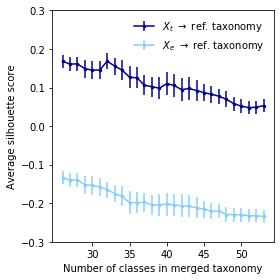

In [30]:
plt.figure(figsize = (4,4))
plt.errorbar(df_n_class['n_classes'].values,df_n_class['sil_T']['mean'].values,df_n_class['sil_T']['std'].values,
             color='darkblue',label=r'$X_{t}$ $\rightarrow$ ref. taxonomy',
             linestyle='-',marker='.',ms=5)
plt.errorbar(df_n_class['n_classes'].values,df_n_class['sil_E']['mean'].values,df_n_class['sil_T']['std'].values,
             color='lightskyblue',label=r'$X_{e}$ $\rightarrow$ ref. taxonomy',
             linestyle='-',marker='.',ms=5)

ax = plt.gca()
ax.set_ylabel('Average silhouette score')
ax.set_xlabel('Number of classes in merged taxonomy')
ax.set_xticks(np.arange(30,55,5))
ax.set_ylim(-0.3,0.3)
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig(fig_path+f'avg_silhouette_scores_taxonomy_best_{n_best:d}.pdf',dpi=300)
plt.savefig(fig_path+f'Fig_ED_8.jpg',dpi=300)
plt.savefig(fig_path+f'Fig_ED_8.pdf')
plt.show()

#### Coupled representations with GMM labels and 33-taxonomy

In [10]:
df_sample_list_E_gmm= []
df_label_list_E_gmm = []

df_sample_list_T_gmm = []
df_label_list_T_gmm = []

df_sample_list_E_tax= []
df_label_list_E_tax = []

df_sample_list_T_tax = []
df_label_list_T_tax = []

tax_labels,n_classes = taxonomy_assignments(O['cluster'].copy(),datadict=O.copy(),n_required_classes=33, merge_on='well_sampled')

for k in range(n_best):
    all_inds = O['well_sampled_ind'].copy()
    test_inds = folds_1[best_TE_model_key[k]]['well_sampled_test_ind'].copy()
    
    #zE -> Gmm E
    zE = folds_1[best_TE_model_key[k]]['zE'][test_inds,:].copy()
    lbl = folds_1[best_TE_model_key[k]]['ccE_lbl_matched'][test_inds].copy()
    df_sample,df_label = silhouette_analysis(z=zE,lbl=lbl)
    df_sample_list_E_gmm.append(df_sample)
    df_label_list_E_gmm.append(df_label)
    
    #zE -> taxonomy
    zE = folds_1[best_TE_model_key[k]]['zE'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zE,lbl=lbl)
    df_sample_list_E_tax.append(df_sample)
    df_label_list_E_tax.append(df_label)
    
    #zT -> Gmm T
    zT = folds_1[best_TE_model_key[k]]['zT'][test_inds,:].copy()
    lbl = folds_1[best_TE_model_key[k]]['ccT_lbl_matched'][test_inds].copy()
    df_sample,df_label = silhouette_analysis(z=zT,lbl=lbl)
    df_sample_list_T_gmm.append(df_sample)
    df_label_list_T_gmm.append(df_label)
    
    #zT -> taxonomy
    zT = folds_1[best_TE_model_key[k]]['zT'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zT,lbl=lbl)
    df_sample_list_T_tax.append(df_sample)
    df_label_list_T_tax.append(df_label)

In [11]:
s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_E_gmm])
print(f'Coupled E rep. with GMM: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_T_gmm])
print(f'Coupled T rep. with GMM: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_E_tax])
print(f'Coupled E rep. with taxonomy: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_T_tax])
print(f'Coupled T rep. with taxonomy: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

Coupled E rep. with GMM: s = 0.044 + 0.017
Coupled T rep. with GMM: s = 0.235 + 0.009
Coupled E rep. with taxonomy: s = -0.133 + 0.008
Coupled T rep. with taxonomy: s = 0.135 + 0.009


#### Uncoupled representation with 33-label taxonomy

In [12]:
df_sample_list_E_tax_unc = []
df_label_list_E_tax_unc = []

df_sample_list_T_tax_unc = []
df_label_list_T_tax_unc = []

tax_labels,n_classes = taxonomy_assignments(O['cluster'].copy(),datadict=O.copy(),n_required_classes=33, merge_on='well_sampled')

for i in folds_0.keys():
    
    zE = folds_0[i]['zE'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zE,lbl=lbl)
    df_sample_list_E_tax_unc.append(df_sample)
    df_label_list_E_tax_unc.append(df_label)
    
    zT = folds_1[i]['zT'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zT,lbl=lbl)
    df_sample_list_T_tax_unc.append(df_sample)
    df_label_list_T_tax_unc.append(df_label)

In [13]:
s_tax_unc = np.array([df['sil'].mean() for df in df_sample_list_E_tax_unc])
print(f'Uncoupled E rep. with taxonomy: s = {np.mean(s_tax_unc):0.3f} + {np.std(s_tax_unc):0.3f}')

s_tax_unc = np.array([df['sil'].mean() for df in df_sample_list_T_tax_unc])
print(f'Uncoupled T rep. with taxonomy: s = {np.mean(s_tax_unc):0.3f} + {np.std(s_tax_unc):0.3f}')

Uncoupled E rep. with taxonomy: s = -0.188 + 0.026
Uncoupled T rep. with taxonomy: s = 0.132 + 0.022


In [14]:
x = np.mean(df_label_list_E_gmm[0]["sil"]["mean"].values)
y = np.std(df_label_list_E_gmm[0]["sil"]["mean"].values)
print(f'Consensus    {x:0.2f} + {y:0.2f}')
x=np.mean(df_label_list_E_tax[0]['sil']['mean'].values)
y=np.std(df_label_list_E_tax[0]['sil']['mean'].values)
print(f'Taxonomy 33   {x:0.2f} + {y:0.2f}')

Consensus    0.10 + 0.28
Taxonomy 33   -0.17 + 0.28


In [26]:
df_csv = pd.DataFrame({'consensus_lbl':df_label_list_E_gmm[0]['sil']['mean'].values,
                       'reference_lbl':df_label_list_E_tax[0]['sil']['mean'].values,
                       'reference_lbl_unc':df_label_list_E_tax_unc[0]['sil']['mean'].values})
df_csv.to_csv(fig_path+'Fig_3e_source.csv',index=True)

df_csv = pd.DataFrame({'consensus_lbl':df_label_list_T_gmm[0]['sil']['mean'].values,
                       'reference_lbl':df_label_list_T_tax[0]['sil']['mean'].values,
                       'reference_lbl_unc':df_label_list_T_tax_unc[0]['sil']['mean'].values})
df_csv.to_csv(fig_path+'Fig_3d_source.csv',index=True)

In [37]:
import seaborn as sns
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

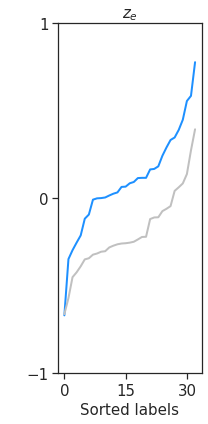

In [56]:
fs = 15
plt.figure(figsize=(3,6))
col=['dodgerblue','firebrick','silver']
plt.plot(df_label_list_E_gmm[0]['sil']['mean'].values, lw=2, color=col[0],label=r'consensus labels')
#plt.plot(df_label_list_E_tax[0]['sil']['mean'].values,lw=2, color=col[1],label=r'ref. taxonomy (33)')
plt.plot(df_label_list_E_tax_unc[0]['sil']['mean'].values, lw=2, color=col[2],label=r'ref. taxonomy (33)')


ax = plt.gca()
ax.set_title(r'$z_e$',fontsize=fs)
ax.set_xlabel('Sorted labels',fontsize=fs)
#ax.set_ylabel('Avgerage silhouette score per label',fontsize=fs)
ax.set_ylabel(' ',fontsize=fs)
#ax.set_ylabel('Avgerage silhouette score per label',fontsize=fs,rotation=-90)
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylim(-1,1)
ax.set_yticks([-1,0,1])
ax.set_xticks([0,15,30])
#ax.set_yticklabels([' ',' ',' '])
plt.setp(ax.get_xticklabels(), fontsize=fs)
plt.setp(ax.get_yticklabels(), fontsize=fs)
#plt.legend(fontsize=12,frameon=False)
plt.tight_layout()
#plt.savefig(fig_path+f'gmm_labels_vs_taxonomy33_ze.png',dpi=300)
#plt.savefig(fig_path+f'Fig_3e.pdf')
plt.savefig(fig_path+f'Fig_ED_8c.pdf')
plt.show()

Consensus    0.23 + 0.27
Taxonomy 33   0.02 + 0.33


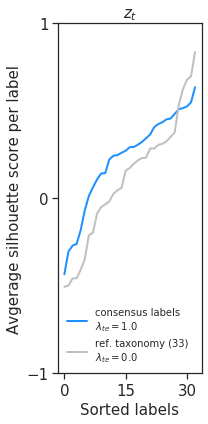

In [53]:
plt.figure(figsize=(3,6))

plt.plot(df_label_list_T_gmm[0]['sil']['mean'].values,  lw=2,  color=col[0],label=r'consensus labels'+'\n'+ r'$\lambda_{te}=1.0$')
#plt.plot(df_label_list_T_tax[0]['sil']['mean'].values,  lw=2,  color=col[1],label=r'ref. taxonomy (33)')
plt.plot(df_label_list_T_tax_unc[0]['sil']['mean'].values,  lw=2,  color=col[2],label=r'ref. taxonomy (33)'+'\n'+ r'$\lambda_{te}=0.0$')

x = np.mean(df_label_list_T_gmm[0]["sil"]["mean"].values)
y = np.std(df_label_list_T_gmm[0]["sil"]["mean"].values)
print(f'Consensus    {x:0.2f} + {y:0.2f}')
x=np.mean(df_label_list_T_tax[0]['sil']['mean'].values)
y=np.std(df_label_list_T_tax[0]['sil']['mean'].values)
print(f'Taxonomy 33   {x:0.2f} + {y:0.2f}')


ax = plt.gca()
ax.set_title(r'$z_t$',fontsize=fs)
ax.set_xlabel('Sorted labels',fontsize=fs)
#ax.set_ylabel('Avgerage silhouette score per label',fontsize=fs,rotation=-90)
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()
ax.set_ylabel('Avgerage silhouette score per label',fontsize=fs)
ax.set_ylim(-1,1)
ax.set_yticks([-1,0,1])
ax.set_xticks([0,15,30])
plt.setp(ax.get_xticklabels(), fontsize=fs)
plt.setp(ax.get_yticklabels(), fontsize=fs)
plt.tight_layout()
#plt.savefig(fig_path+f'gmm_labels_vs_taxonomy33_zt.png',dpi=300)
#plt.savefig(fig_path+f'Fig_3d.pdf')
plt.legend(fontsize=10,frameon=False)
plt.savefig(fig_path+f'Fig_ED_8b.pdf')
plt.show()

In [12]:
n_worst=10
unreliable_clusters = np.intersect1d(df_label_list_T_gmm[0][0:n_worst]['lbl'].values,df_label_list_E_gmm[0][0:n_worst]['lbl'].values)

In [13]:
df_label_list_E_gmm[0][df_label_list_E_gmm[0]['lbl'].isin(unreliable_clusters)]

lbl       sil          
           mean       std
0   1 -0.668872  0.154438
1  13 -0.347262  0.134515
2   9 -0.296254  0.112122
3  28 -0.253059  0.193271
4   7 -0.211839  0.200849
6  17 -0.092525  0.150189
9  24  0.001514  0.190524

In [14]:
df_label_list_T_gmm[0][df_label_list_T_gmm[0]['lbl'].isin(unreliable_clusters)]

lbl       sil          
           mean       std
0   1 -0.433628  0.335519
1   7 -0.304104  0.206137
2   9 -0.270276  0.086487
3  13 -0.260740  0.212850
4  28 -0.181354  0.198278
6  17  0.013605  0.284825
9  24  0.141834  0.236050